# Toy Model for Solute Transport: MESS LP Comparison (Shared Draws)

This notebook compares MESS without LP (uniform) vs LP (angular/Euclidean) at $d=10$, using the same shared draws as the shared-draws sweep.

Notes:
- No MH runs.
- Existing no-LP chains are loaded from the shared-draws sweep output directory.
- LP chains are saved in the same directory with LP-specific filenames.

## Imports

In [1]:
import os
import sys
import time
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(repo_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from mess.problems.advection_diffusion import (
    make_omegas_power,
    make_Astar_nn,
    make_Astar_from_atrue,
    params_from_skew,
    prior_diag_from_powerlaw,
    solve_theta,
)
from mess.problems.advection_diffusion import AdvectionDiffusionToy
from mess.algorithms.mess import mess_step
from mess.algorithms.effective_sample_size import estimate_effective_sample_size
from mess.plotting.diagnostics import make_hist_grid_comps

## Configuration

In [2]:
# Sweep configuration
seed_data = 0
seed_mcmc = 0
n_iters = 5000
burn_in = 100
thin = 1
max_lag = 1500

d_list = [10]
d_max = 100
M_list = [10, 50]

# Data hyperparameters
kappa = 0.02
sigma = 0.5
alpha = 3
gamma = 2
tau2 = 2.0
a_mode = 'nearest_neighbor'
use_prior_A = True
shared_draws_seed = seed_data

if max(d_list) > d_max:
    raise ValueError('d_max must be >= max(d_list)')

# Observation configuration
obs_highest_freq = 6
obs_bandwidth = 3
obs_config = 'central_modes'

# LP configuration
lp_lam = 0

# Run flags
run_mess_no_lp = False  # existing results already computed
run_lp_angular = True
run_lp_euclidean = True
recompute_corrupt_chains = True

# Diagnostics configuration
capture_diagnostics = False

# Cache generated datasets per dimension.
datasets_by_dim = {}

# Existing no-LP output directory (shared-draws sweep)
output_dir_no_lp = Path(
    '/Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/'
    f'priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters{n_iters}'
 )

# LP chains are saved in the same directory, with LP-specific filenames
output_dir_lp = output_dir_no_lp
output_dir_lp.mkdir(parents=True, exist_ok=True)

# Reports directory for figures, tables, and metrics.
run_tag = (
    f'priorA{use_prior_A}_obs_{obs_config}_tau2{tau2}_sigma{sigma}_seed{seed_data}_'
    f'dmax{d_max}_Niters{n_iters}_d10_lp_compare'
 )
reports_dir = Path(repo_root) / 'reports' / 'AD_toy_dim_M_sweep_shared_draws_lp_compare' / run_tag
reports_dir.mkdir(parents=True, exist_ok=True)

print('No-LP output dir:', output_dir_no_lp)
print('LP output dir:', output_dir_lp)
print('Reports dir:', reports_dir)

No-LP output dir: /Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters5000
LP output dir: /Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters5000
Reports dir: /Users/guillers/Documents/GitHub/mess/reports/AD_toy_dim_M_sweep_shared_draws_lp_compare/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters5000_d10_lp_compare


## Helpers

In [3]:
def compute_msjd_per_param(chain):
    if chain.shape[0] < 2:
        return np.zeros(chain.shape[1])
    jumps = np.diff(chain, axis=0)
    msjd = np.mean(jumps * jumps, axis=0)
    return msjd

def compute_ess_per_param(chain, max_lag):
    if chain.shape[0] < 2:
        return np.zeros(chain.shape[1])
    variances = np.var(chain, axis=0)
    if np.all(variances == 0):
        return np.zeros(chain.shape[1])
    ess_vals = estimate_effective_sample_size(chain, max_lag=max_lag)
    ess_vals = np.asarray(ess_vals, dtype=float)
    ess_vals[variances == 0] = 0.0
    return ess_vals

def chain_path(output_dir, d, M, variant):
    if variant == 'mess':
        return output_dir / f'chain_d{d}_mess_M{M}.npz'
    if variant == 'lp_angular':
        return output_dir / f'chain_d{d}_mess_lp_angular_M{M}.npz'
    if variant == 'lp_euclidean':
        return output_dir / f'chain_d{d}_mess_lp_euclidean_M{M}.npz'
    raise ValueError(f'Unknown variant: {variant}')

def diagnostics_path(output_dir, d, M, variant):
    if variant == 'mess':
        return output_dir / f'diagnostics_d{d}_mess_M{M}.npz'
    if variant == 'lp_angular':
        return output_dir / f'diagnostics_d{d}_mess_lp_angular_M{M}.npz'
    if variant == 'lp_euclidean':
        return output_dir / f'diagnostics_d{d}_mess_lp_euclidean_M{M}.npz'
    raise ValueError(f'Unknown variant: {variant}')

def load_chain(output_dir, d, M, variant):
    path = chain_path(output_dir, d, M, variant)
    if not path.exists():
        return None
    try:
        data = np.load(path)
        return data['chain']
    except (zipfile.BadZipFile, ValueError, KeyError) as exc:
        print(f'Corrupt or unreadable chain file: {path.name} ({exc})')
        return None

def load_diagnostics(output_dir, d, M, variant):
    path = diagnostics_path(output_dir, d, M, variant)
    if not path.exists():
        return None
    try:
        data = np.load(path, allow_pickle=True)
        diagnostics = data['diagnostics']
        return diagnostics.tolist()
    except (zipfile.BadZipFile, ValueError, KeyError) as exc:
        print(f'Corrupt or unreadable diagnostics file: {path.name} ({exc})')
        return None

def is_chain_readable(path):
    if not path.exists():
        return False
    try:
        with np.load(path) as data:
            _ = data['chain']
        return True
    except (zipfile.BadZipFile, ValueError, KeyError):
        return False

def is_diagnostics_readable(path):
    if not path.exists():
        return False
    try:
        with np.load(path, allow_pickle=True) as data:
            _ = data['diagnostics']
        return True
    except (zipfile.BadZipFile, ValueError, KeyError):
        return False

def save_chain(path, chain, metadata):
    np.savez_compressed(path, chain=chain, **metadata)

def save_diagnostics(path, diagnostics, metadata):
    diagnostics_array = np.array(diagnostics, dtype=object)
    np.savez_compressed(path, diagnostics=diagnostics_array, **metadata)

def get_obs_indices(dim_value, highest_freq, bandwidth):
    highest_freq = min(highest_freq, dim_value)
    bandwidth = min(bandwidth, dim_value)
    start = max(0, highest_freq - bandwidth + 1)
    return np.arange(start, highest_freq + 1, dtype=int)

def get_param_indices_for_dim(dim, shared_draws):
    cache = shared_draws.setdefault('param_indices_cache', {})
    if dim not in cache:
        iju = shared_draws['param_iju']
        mask = (iju[0] < dim) & (iju[1] < dim)
        cache[dim] = np.nonzero(mask)[0]
    return cache[dim]

def build_shared_draws(d_max, kappa, sigma, alpha, gamma, tau2, offset, a_mode, seed):
    rng = np.random.default_rng(seed)
    m_max = d_max * (d_max - 1) // 2
    prior_diag_max = prior_diag_from_powerlaw(d_max, alpha=alpha, gamma=gamma, tau2=tau2, offset=offset)
    if prior_diag_max.shape != (m_max,):
        raise ValueError(f'prior_diag_max must have shape ({m_max},), got {prior_diag_max.shape}')
    if a_mode == 'nearest_neighbor':
        omegas = make_omegas_power(d_max, beta=alpha, c=2.0 ** (-gamma), offset=offset)
        A_true_max = make_Astar_nn(d_max, omegas)
        a_true_max = params_from_skew(A_true_max)
    elif a_mode == 'prior':
        z_prior = rng.standard_normal(m_max)
        a_true_max = z_prior * np.sqrt(prior_diag_max)
        A_true_max = make_Astar_from_atrue(d_max, a_true_max)
    else:
        raise ValueError('a_mode must be nearest_neighbor or prior')
    g_max = np.zeros(d_max, dtype=float)
    g_max[0] = 1.0
    theta_true_max = solve_theta(d_max, a_true_max, g_max, kappa)
    noise_max = rng.standard_normal(d_max)
    z_init = rng.standard_normal(m_max)
    a_init_max = z_init * np.sqrt(prior_diag_max)
    return {
        'd_max': d_max,
        'm_max': m_max,
        'kappa': kappa,
        'sigma': sigma,
        'alpha': alpha,
        'gamma': gamma,
        'tau2': tau2,
        'offset': offset,
        'a_mode': a_mode,
        'param_iju': np.triu_indices(d_max, k=1),
        'param_indices_cache': {},
        'prior_diag': prior_diag_max,
        'a_true': a_true_max,
        'A_true': A_true_max,
        'g': g_max,
        'theta_true': theta_true_max,
        'noise': noise_max,
        'a_init': a_init_max,
    }

def generate_advection_diffusion_data_shared(dim, obs_indices, shared_draws):
    a_mode_local = shared_draws['a_mode']
    param_idx = get_param_indices_for_dim(dim, shared_draws)
    prior_diag = shared_draws['prior_diag'][param_idx]
    g = shared_draws['g'][:dim]
    if a_mode_local == 'nearest_neighbor':
        omegas = make_omegas_power(
            dim,
            beta=shared_draws['alpha'],
            c=2.0 ** (-shared_draws['gamma']),
            offset=shared_draws['offset'],
        )
        A_true = make_Astar_nn(dim, omegas)
        a_true = params_from_skew(A_true)
        theta_true = solve_theta(dim, a_true, g, shared_draws['kappa'])
    elif a_mode_local == 'prior':
        a_true = shared_draws['a_true'][param_idx]
        A_true = make_Astar_from_atrue(dim, a_true)
        theta_true = shared_draws['theta_true'][:dim]
    else:
        raise ValueError('a_mode must be nearest_neighbor or prior')
    noise = shared_draws['noise'][:dim]
    y = theta_true[obs_indices] + shared_draws['sigma'] * noise[obs_indices]
    a_init = shared_draws['a_init'][param_idx]
    return {
        'dim': dim,
        'kappa': shared_draws['kappa'],
        'alpha': shared_draws['alpha'],
        'gamma': shared_draws['gamma'],
        'tau2': shared_draws['tau2'],
        'sigma': shared_draws['sigma'],
        'obs_indices': obs_indices,
        'prior_diag': prior_diag,
        'a_true': a_true,
        'A_true': A_true,
        'g': g,
        'theta_true': theta_true,
        'y': y,
        'a_init': a_init,
    }

def get_dataset_for_dim(d, seed=0):
    if d in datasets_by_dim:
        return datasets_by_dim[d]
    obs_indices = get_obs_indices(d, obs_highest_freq, obs_bandwidth)
    data = generate_advection_diffusion_data_shared(d, obs_indices, shared_draws)
    data['obs_indices'] = obs_indices
    datasets_by_dim[d] = data
    return data

def build_problem_for_dim(d, seed=0):
    data = get_dataset_for_dim(d, seed=seed)
    obs_indices = data['obs_indices']
    problem = AdvectionDiffusionToy(
        dim=d,
        kappa=kappa,
        sigma=sigma,
        y=data['y'],
        obs_indices=obs_indices,
        g=data['g'],
        prior_diag=data['prior_diag'],
    )
    return problem, data['a_init'], obs_indices, data

In [4]:
shared_draws = build_shared_draws(
    d_max=d_max,
    kappa=kappa,
    sigma=sigma,
    alpha=alpha,
    gamma=gamma,
    tau2=tau2,
    offset=1.0,
    a_mode='prior' if use_prior_A else a_mode,
    seed=shared_draws_seed,
 )

Saved /Users/guillers/Documents/GitHub/mess/reports/AD_toy_dim_M_sweep_shared_draws_lp_compare/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters5000_d10_lp_compare/visual_check_A_theta_y.png


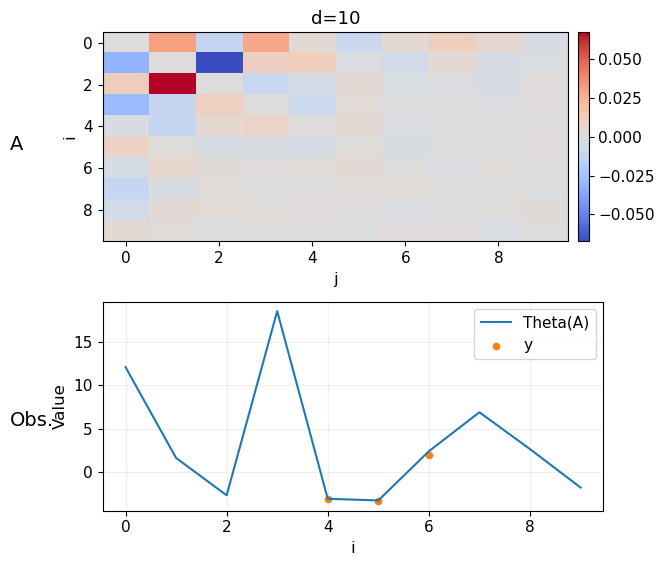

In [5]:
# Visual check: A_true and observations for d=10.
plot_dims = d_list
n_cols = len(plot_dims)
fig, axes = plt.subplots(2, n_cols, figsize=(7, 6))
axes = np.array(axes)
if axes.ndim == 1:
    axes = axes.reshape(2, n_cols)
else:
    axes = np.atleast_2d(axes)

row_label_size = 14
title_size = 13
tick_size = 11
axis_label_size = 12
cbar_tick_size = 11

last_im = None
for col_idx, d_cur in enumerate(plot_dims):
    data = get_dataset_for_dim(d_cur, seed=seed_data)

    ax_A = axes[0, col_idx]
    ax_obs = axes[1, col_idx]

    last_im = ax_A.imshow(data['A_true'], cmap='coolwarm', aspect='auto')
    if col_idx == 0:
        ax_A.set_ylabel('i', fontsize=axis_label_size)
    ax_A.set_xlabel('j', fontsize=axis_label_size)
    ax_A.tick_params(axis='both', labelsize=tick_size)

    theta_true = data['theta_true']
    obs_indices = data['obs_indices']
    ax_obs.plot(
        np.arange(d_cur),
        theta_true,
        color='tab:blue',
        label='Theta(A)',
    )
    ax_obs.scatter(obs_indices, data['y'], color='tab:orange', s=20, label='y')
    if col_idx == 0:
        ax_obs.set_ylabel('Value', fontsize=axis_label_size)
    ax_obs.set_xlabel('i', fontsize=axis_label_size)
    ax_obs.grid(alpha=0.2)
    ax_obs.legend(loc='best', fontsize=tick_size)
    ax_obs.tick_params(axis='both', labelsize=tick_size)

    ax_A.set_title(f'd={d_cur}', fontsize=title_size)

if last_im is not None:
    cbar = fig.colorbar(last_im, ax=axes[0, -1], fraction=0.05, pad=0.02)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

fig.text(0.01, 0.73, 'A', rotation=0, va='center', ha='left', fontsize=row_label_size)
fig.text(0.01, 0.27, 'Obs.', rotation=0, va='center', ha='left', fontsize=row_label_size)
fig.tight_layout(rect=[0.05, 0.02, 0.95, 0.98])

fig_path = reports_dir / 'visual_check_A_theta_y.png'
fig.savefig(fig_path, dpi=600, bbox_inches='tight')
print(f'Saved {fig_path}')

plt.show()

## Run Chains (MESS no LP, LP angular, LP euclidean)

In [7]:
variants = {
    'mess': {
        'label': 'MESS (no LP)',
        'use_lp': False,
        'distance': None,
    },
    'lp_angular': {
        'label': 'MESS LP (angular)',
        'use_lp': True,
        'distance': 'angular',
    },
    'lp_euclidean': {
        'label': 'MESS LP (euclidean)',
        'use_lp': True,
        'distance': 'euclidean',
    },
}

def _run_mess_chain(d_cur, M, variant_key):
    variant = variants[variant_key]
    label = variant['label']
    if variant_key == 'mess':
        out_dir = output_dir_no_lp
    else:
        out_dir = output_dir_lp
    out_path = chain_path(out_dir, d_cur, M, variant_key)
    diag_path = diagnostics_path(out_dir, d_cur, M, variant_key)
    chain_ok = out_path.exists() and is_chain_readable(out_path)
    diag_ok = diag_path.exists() and is_diagnostics_readable(diag_path)
    if chain_ok and (not capture_diagnostics or diag_ok):
        print(f'Skip existing: {out_path.name}')
        return
    if out_path.exists() and not is_chain_readable(out_path):
        if recompute_corrupt_chains:
            print(f'Recomputing corrupt chain: {out_path.name}')
        else:
            print(f'Corrupt chain found, skipping: {out_path.name}')
            return
    if capture_diagnostics and chain_ok and not diag_ok:
        print(f'Recomputing to collect diagnostics: {out_path.name}')
    print(f'\nStart {label}: d={d_cur}, M={M}, n_iters={n_iters}, burn_in={burn_in}, thin={thin}')
    problem_cur, x0_cur, obs_indices_cur, _ = build_problem_for_dim(d_cur, seed=seed_data)
    print(f'Obs indices: {obs_indices_cur.tolist()}')
    rng = np.random.default_rng(seed_mcmc)
    chain = np.zeros((n_iters + 1, x0_cur.shape[0]))
    chain[0] = x0_cur.copy()
    x = x0_cur.copy()
    diagnostics = [] if capture_diagnostics else None
    t0 = time.perf_counter()
    for t in range(n_iters):
        if capture_diagnostics:
            x, _, _, diag = mess_step(
                x,
                problem_cur,
                rng,
                M=M,
                use_lp=variant['use_lp'],
                distance_metric=variant['distance'] if variant['use_lp'] else 'angular',
                lam=lp_lam,
                return_diagnostics=True,
            )
            diagnostics.append(diag)
        else:
            x, _, _ = mess_step(
                x,
                problem_cur,
                rng,
                M=M,
                use_lp=variant['use_lp'],
                distance_metric=variant['distance'] if variant['use_lp'] else 'angular',
                lam=lp_lam,
            )
        chain[t + 1] = x
    t1 = time.perf_counter()
    post = chain[::thin]
    metadata = {
        'alg': 'mess',
        'M': M,
        'd': d_cur,
        'use_lp': variant['use_lp'],
        'distance_metric': variant['distance'],
        'lp_lam': lp_lam,
        'n_iters': n_iters,
        'burn_in': burn_in,
        'thin': thin,
        'seed_mcmc': seed_mcmc,
        'seed_data': seed_data,
        'runtime_sec': t1 - t0,
    }
    save_chain(out_path, post, metadata)
    print(f'Saved {out_path.name}')
    if capture_diagnostics:
        diag_metadata = dict(metadata)
        diag_metadata['diag_version'] = 'v1'
        save_diagnostics(diag_path, diagnostics, diag_metadata)
        print(f'Saved {diag_path.name}')

print('Starting sweep: d_list=', d_list, 'M_list=', M_list)
for d_cur in d_list:
    if run_mess_no_lp:
        for M in M_list:
            _run_mess_chain(d_cur, M, 'mess')
    if run_lp_angular:
        for M in M_list:
            _run_mess_chain(d_cur, M, 'lp_angular')
    if run_lp_euclidean:
        for M in M_list:
            _run_mess_chain(d_cur, M, 'lp_euclidean')

print('Sweep completed.')

Starting sweep: d_list= [10] M_list= [10, 50]

Start MESS LP (angular): d=10, M=10, n_iters=500000, burn_in=10000, thin=1
Obs indices: [4, 5, 6]
Saved chain_d10_mess_lp_angular_M10.npz

Start MESS LP (angular): d=10, M=50, n_iters=500000, burn_in=10000, thin=1
Obs indices: [4, 5, 6]
Saved chain_d10_mess_lp_angular_M50.npz

Start MESS LP (euclidean): d=10, M=10, n_iters=500000, burn_in=10000, thin=1
Obs indices: [4, 5, 6]
Saved chain_d10_mess_lp_euclidean_M10.npz

Start MESS LP (euclidean): d=10, M=50, n_iters=500000, burn_in=10000, thin=1
Obs indices: [4, 5, 6]
Saved chain_d10_mess_lp_euclidean_M50.npz
Sweep completed.


## Proposal Diagnostics (Accepted Index + Distances)

In [26]:
diag_variant = 'lp_angular'  # 'mess', 'lp_angular', 'lp_euclidean'
diag_d = d_list[0]
diag_M = M_list[0]
save_diag_figs = True
diagnostics_dir = reports_dir / 'proposal_diagnostics'
diagnostics_dir.mkdir(parents=True, exist_ok=True)

diag_output_dir = output_dir_no_lp if diag_variant == 'mess' else output_dir_lp
diagnostics = load_diagnostics(diag_output_dir, diag_d, diag_M, diag_variant)

if diagnostics is None:
    print(f'No diagnostics found for {diag_variant} at d={diag_d}, M={diag_M}.')
else:
    n_iters_diag = len(diagnostics)
    accepted_indices = np.full(n_iters_diag, np.nan)
    accepted_angular = np.full(n_iters_diag, np.nan)
    accepted_euclidean = np.full(n_iters_diag, np.nan)
    mean_other_angular = np.full(n_iters_diag, np.nan)
    mean_other_euclidean = np.full(n_iters_diag, np.nan)
    valid_counts = np.zeros(n_iters_diag, dtype=int)

    for t, diag_iter in enumerate(diagnostics):
        if not diag_iter:
            continue
        last_entry = diag_iter[-1]
        accepted_idx = last_entry.get('accepted_index', None)
        valid_idx = last_entry.get('valid_indices', None)
        if accepted_idx is None or valid_idx is None:
            continue
        accepted_indices[t] = accepted_idx
        valid_counts[t] = len(valid_idx)
        angular = last_entry.get('angular_distances', None)
        euclidean = last_entry.get('euclidean_distances', None)
        if angular is not None:
            accepted_angular[t] = angular[accepted_idx]
            other = [i for i in valid_idx if i != accepted_idx]
            if other:
                mean_other_angular[t] = float(np.mean(angular[other]))
        if euclidean is not None:
            accepted_euclidean[t] = euclidean[accepted_idx]
            other = [i for i in valid_idx if i != accepted_idx]
            if other:
                mean_other_euclidean[t] = float(np.mean(euclidean[other]))

    print('Diagnostics preview:')
    preview_count = min(5, n_iters_diag)
    for t in range(preview_count):
        print(
            f'iter={t}: accepted_idx={accepted_indices[t]}, '
            f'valid={valid_counts[t]}, '
            f'ang={accepted_angular[t]:.3g}, '
            f'euc={accepted_euclidean[t]:.3g}'
        )

    fig, ax = plt.subplots(figsize=(11, 3.5))
    ax.plot(accepted_indices, color='tab:blue', linewidth=0.7, alpha=0.8)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Accepted proposal index')
    ax.set_title(f'Accepted proposal index ({diag_variant}, d={diag_d}, M={diag_M})')
    ax.grid(alpha=0.2)
    if save_diag_figs:
        fig_path = diagnostics_dir / f'accepted_index_{diag_variant}_d{diag_d}_M{diag_M}.png'
        fig.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f'Saved {fig_path}')
    plt.show()

    fig, axes = plt.subplots(2, 1, figsize=(11, 6.5), sharex=True)
    axes[0].plot(accepted_angular, color='tab:green', linewidth=0.8, label='Accepted angular')
    axes[0].plot(mean_other_angular, color='tab:orange', linewidth=0.8, alpha=0.8, label='Mean other valid angular')
    axes[0].set_ylabel('Angular distance')
    axes[0].grid(alpha=0.2)
    axes[0].legend(loc='best')

    axes[1].plot(accepted_euclidean, color='tab:purple', linewidth=0.8, label='Accepted euclidean')
    axes[1].plot(mean_other_euclidean, color='tab:red', linewidth=0.8, alpha=0.8, label='Mean other valid euclidean')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Euclidean distance')
    axes[1].grid(alpha=0.2)
    axes[1].legend(loc='best')

    fig.suptitle(f'Distances to candidates ({diag_variant}, d={diag_d}, M={diag_M})')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    if save_diag_figs:
        fig_path = diagnostics_dir / f'distances_{diag_variant}_d{diag_d}_M{diag_M}.png'
        fig.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f'Saved {fig_path}')
    plt.show()

No diagnostics found for lp_angular at d=10, M=10.


## Trace/Histogram Panels

/var/folders/jw/64vkfdg1407__zgldz2hpjfr0000gn/T/ipykernel_22021/1619996460.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.86])


Saved /Users/guillers/Documents/GitHub/mess/reports/AD_toy_dim_M_sweep_shared_draws_lp_compare/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters100000_d10_lp_compare/trace_hist_panels/trace_hist_d10_M10_comp0.png


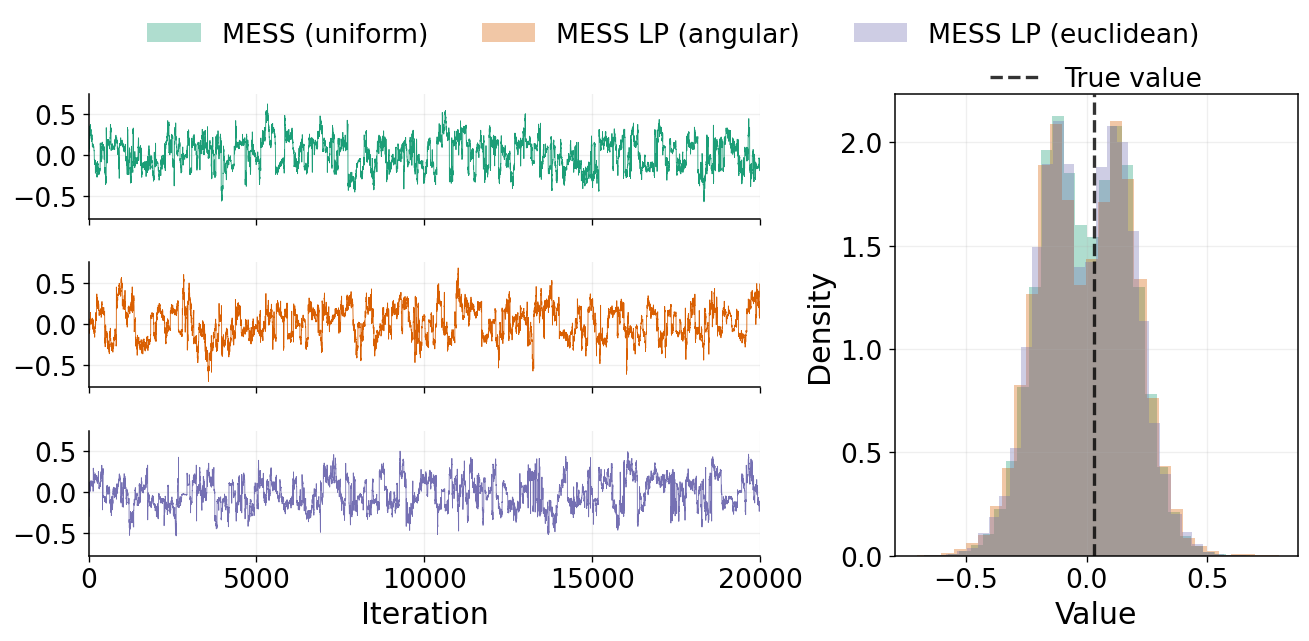

/var/folders/jw/64vkfdg1407__zgldz2hpjfr0000gn/T/ipykernel_22021/1619996460.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.86])


Saved /Users/guillers/Documents/GitHub/mess/reports/AD_toy_dim_M_sweep_shared_draws_lp_compare/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters100000_d10_lp_compare/trace_hist_panels/trace_hist_d10_M50_comp0.png


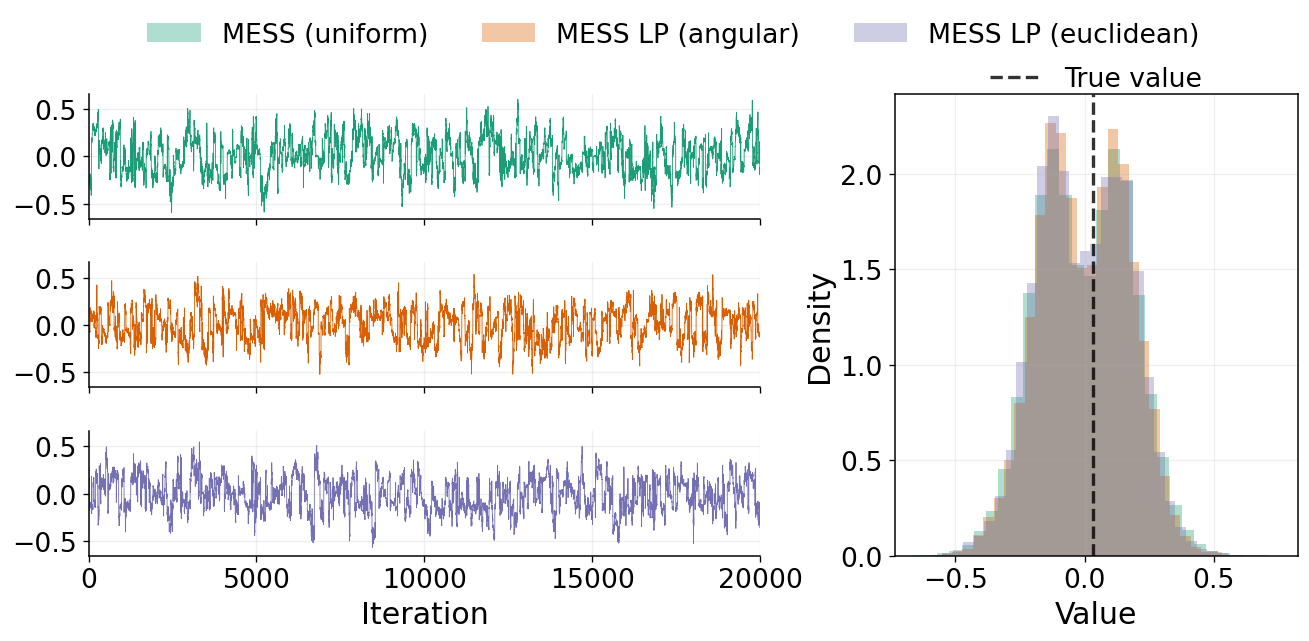

/var/folders/jw/64vkfdg1407__zgldz2hpjfr0000gn/T/ipykernel_22021/1619996460.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.86])


Saved /Users/guillers/Documents/GitHub/mess/reports/AD_toy_dim_M_sweep_shared_draws_lp_compare/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters100000_d10_lp_compare/trace_hist_panels/trace_hist_d10_M10_comp1.png


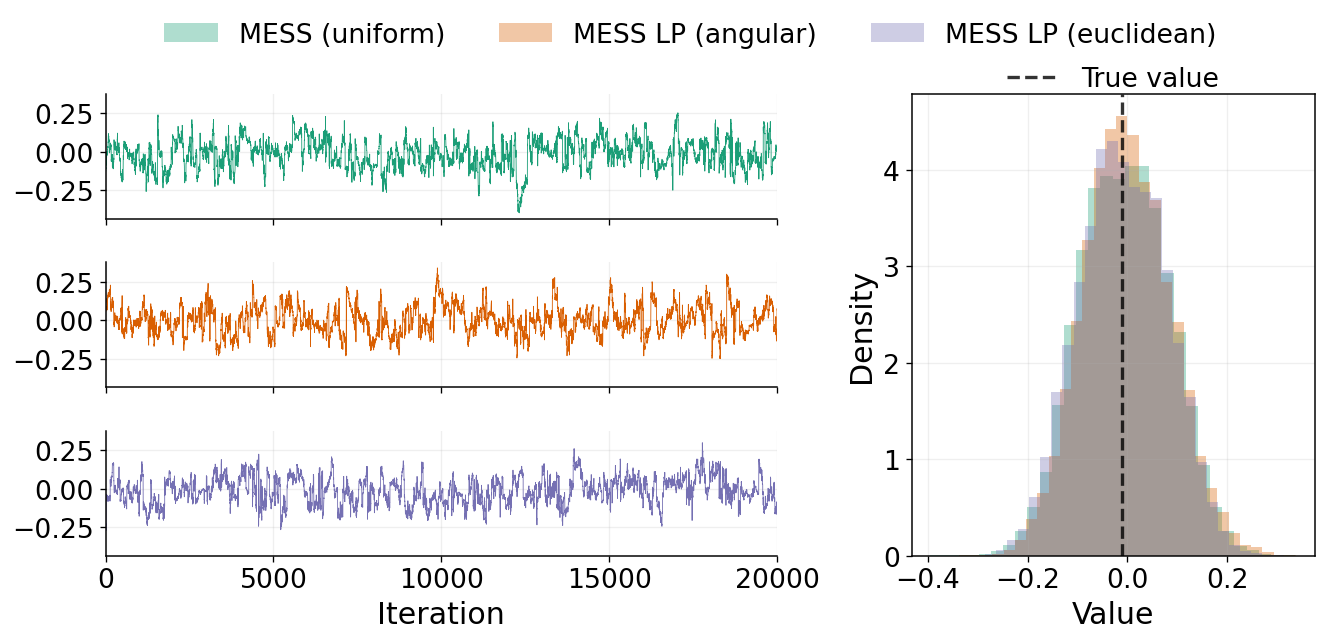

/var/folders/jw/64vkfdg1407__zgldz2hpjfr0000gn/T/ipykernel_22021/1619996460.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.86])


Saved /Users/guillers/Documents/GitHub/mess/reports/AD_toy_dim_M_sweep_shared_draws_lp_compare/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters100000_d10_lp_compare/trace_hist_panels/trace_hist_d10_M50_comp1.png


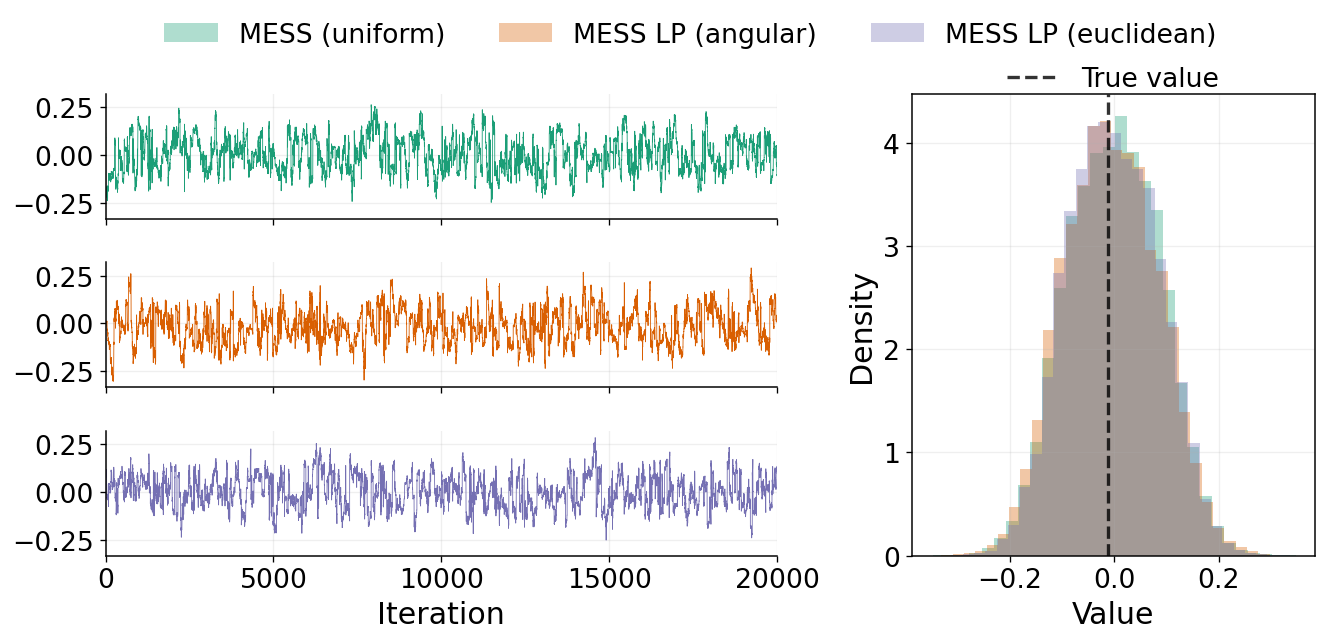

In [27]:
trace_iters = 20000
hist_bins = 30
panel_comps = [0, 1]
hist_d = 10
panel_M_list = [10, 50]
font_size = 18
save_figs = True
panel_dir = reports_dir / 'trace_hist_panels'
panel_dir.mkdir(parents=True, exist_ok=True)
trace_xticks = [0, 5000, 10000, 15000, 20000]

def get_component_labels(dim_value, comps):
    labels = []
    for k in comps:
        count = 0
        found = False
        for i in range(dim_value):
            for j in range(i + 1, dim_value):
                if count == k:
                    labels.append(f'a_{{{i}{j}}}')
                    found = True
                    break
                count += 1
            if found:
                break
        if not found:
            labels.append(f'param_{k}')
    return labels

def _load_chain_for_plot(d_cur, variant_key, M):
    if variant_key == 'mess':
        return load_chain(output_dir_no_lp, d_cur, M, 'mess'), 'MESS (uniform)'
    if variant_key == 'lp_angular':
        return load_chain(output_dir_lp, d_cur, M, 'lp_angular'), 'MESS LP (angular)'
    if variant_key == 'lp_euclidean':
        return load_chain(output_dir_lp, d_cur, M, 'lp_euclidean'), 'MESS LP (euclidean)'
    raise ValueError(f'Unknown variant: {variant_key}')

def plot_trace_hist_panel(d_cur, comp, M):
    algorithms = [
        ('mess', 'MESS (uniform)', '#1b9e77'),
        ('lp_angular', 'MESS LP (angular)', '#d95f02'),
        ('lp_euclidean', 'MESS LP (euclidean)', '#7570b3'),
    ]
    chains_dict = {}
    for key, label, _ in algorithms:
        chain, _ = _load_chain_for_plot(d_cur, key, M)
        if chain is None or chain.size == 0:
            print(f'Missing chain for {label} at d={d_cur}, M={M}')
            chains_dict[key] = None
        else:
            chains_dict[key] = chain[burn_in::thin]

    data_hist = get_dataset_for_dim(d_cur, seed=seed_data)
    true_val = float(data_hist['a_true'][comp])
    label_map = dict(zip(panel_comps, get_component_labels(d_cur, panel_comps)))

    n_algs = len(algorithms)
    fig = plt.figure(figsize=(13, 5.0))
    gs = fig.add_gridspec(n_algs, 2, width_ratios=[2.0, 1.2], wspace=0.25, hspace=0.35)

    all_data = []
    for key, _, _ in algorithms:
        chain = chains_dict.get(key)
        if chain is not None and chain.size > 0:
            all_data.append(chain[:trace_iters, comp])
    if all_data:
        data_min = np.min([np.min(d) for d in all_data])
        data_max = np.max([np.max(d) for d in all_data])
    else:
        data_min, data_max = 0.0, 1.0
    data_range = data_max - data_min if data_max != data_min else 1.0

    for alg_idx, (alg_key, alg_label, color) in enumerate(algorithms):
        ax_trace = fig.add_subplot(gs[alg_idx, 0])
        chain = chains_dict.get(alg_key)
        if chain is None or chain.size == 0:
            ax_trace.set_xlim([0, trace_iters])
            ax_trace.set_xticks(trace_xticks)
            ax_trace.set_yticks([])
            ax_trace.set_xticklabels([])
            ax_trace.set_yticklabels([])
            ax_trace.grid(False)
            ax_trace.spines['top'].set_visible(False)
            ax_trace.spines['right'].set_visible(False)
            ax_trace.spines['left'].set_visible(False)
            ax_trace.spines['bottom'].set_visible(False)
            if alg_idx == n_algs - 1:
                ax_trace.set_xlabel('Iteration', fontsize=font_size)
            continue
        series = chain[:trace_iters, comp]
        ax_trace.plot(series, color=color, linewidth=0.5, label=alg_label)
        ax_trace.set_ylim([data_min - 0.05 * data_range, data_max + 0.05 * data_range])
        ax_trace.set_xlim([0, trace_iters])
        ax_trace.set_xticks(trace_xticks)
        ax_trace.grid(alpha=0.2)
        ax_trace.tick_params(labelsize=font_size - 2)
        ax_trace.spines['top'].set_visible(False)
        ax_trace.spines['right'].set_visible(False)
        if alg_idx < n_algs - 1:
            ax_trace.set_xticklabels([])
        else:
            ax_trace.set_xlabel('Iteration', fontsize=font_size)

    ax_hist = fig.add_subplot(gs[:, 1])
    legend_handles = []
    legend_labels = []
    for alg_key, alg_label, color in algorithms:
        chain = chains_dict.get(alg_key)
        if chain is None or chain.size == 0:
            continue
        _, _, patches = ax_hist.hist(
            chain[:, comp],
            bins=hist_bins,
            density=True,
            alpha=0.35,
            color=color,
            label=alg_label,
        )
        if patches:
            legend_handles.append(patches[0])
            legend_labels.append(alg_label)
    true_line = ax_hist.axvline(
        true_val,
        color='black',
        linestyle='--',
        linewidth=2,
        alpha=0.8,
        label='True value',
    )
    ax_hist.set_xlabel('Value', fontsize=font_size)
    ax_hist.set_ylabel('Density', fontsize=font_size)
    ax_hist.grid(alpha=0.2)
    ax_hist.tick_params(labelsize=font_size - 2)

    if legend_handles:
        fig.legend(
            legend_handles,
            legend_labels,
            loc='upper center',
            ncol=len(legend_labels),
            bbox_to_anchor=(0.5, 1.04),
            fontsize=font_size - 2,
            frameon=False,
        )
    ax_hist.legend(
        handles=[true_line],
        labels=['True value'],
        loc='lower center',
        bbox_to_anchor=(0.5, 0.98),
        fontsize=font_size - 2,
        frameon=False,
        borderaxespad=0.0,
    )
    plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.86])
    if save_figs:
        fig_path = panel_dir / f'trace_hist_d{d_cur}_M{M}_comp{comp}.png'
        fig.savefig(fig_path, dpi=600, bbox_inches='tight')
        print(f'Saved {fig_path}')
    plt.show()

for comp in panel_comps:
    for M in panel_M_list:
        plot_trace_hist_panel(hist_d, comp, M)

## Load Chains and Compute ESS/MSJD

In [8]:
def _apply_burnin(chain, burnin):
    if chain is None:
        return None
    if burnin is None or burnin <= 0:
        return chain
    if chain.shape[0] <= burnin:
        return chain[:0]
    return chain[burnin:]

def _unwrap_loaded(value):
    if isinstance(value, np.ndarray) and value.shape == () and value.dtype == object:
        return value.item()
    return value

def load_metrics_npz(metrics_path):
    if metrics_path is None or not metrics_path.exists():
        return None
    cached = dict(np.load(metrics_path, allow_pickle=True))
    return {k: _unwrap_loaded(v) for k, v in cached.items()}

def save_metrics_npz(metrics, metrics_path, components):
    metrics_to_save = dict(metrics)
    metrics_to_save['components'] = np.array(metrics.get('components', components), dtype=int)
    metrics_to_save.pop('d_list', None)
    metrics_to_save.pop('M_list', None)
    np.savez_compressed(
        metrics_path,
        **metrics_to_save,
        d_list=np.array(d_list),
        M_list=np.array(M_list),
    )
    print(f'Saved metrics to {metrics_path}')

def compute_metrics_for_variant(variant_key, burnin=10000, max_lag=1500, components=None, first_samples_total=None):
    components_list = list(components) if components is not None else None
    if components_list is None:
        components_list = list(range(max(d_list)))
    metrics = {
        'ess_by_M': {M: [] for M in M_list},
        'msjd_by_M': {M: [] for M in M_list},
        'ess_by_M_components': {M: [] for M in M_list},
        'msjd_by_M_components': {M: [] for M in M_list},
        'components': components_list,
    }
    for d_cur in d_list:
        for M in M_list:
            if variant_key == 'mess':
                chain = load_chain(output_dir_no_lp, d_cur, M, 'mess')
            else:
                chain = load_chain(output_dir_lp, d_cur, M, variant_key)
            if chain is None or chain.size == 0:
                metrics['ess_by_M'][M].append(np.nan)
                metrics['msjd_by_M'][M].append(np.nan)
                metrics['ess_by_M_components'][M].append([np.nan] * len(components_list))
                metrics['msjd_by_M_components'][M].append([np.nan] * len(components_list))
                continue
            if first_samples_total is not None:
                chain = chain[:first_samples_total]
            chain = _apply_burnin(chain, burnin)
            if chain is None or chain.size == 0:
                metrics['ess_by_M'][M].append(np.nan)
                metrics['msjd_by_M'][M].append(np.nan)
                metrics['ess_by_M_components'][M].append([np.nan] * len(components_list))
                metrics['msjd_by_M_components'][M].append([np.nan] * len(components_list))
                continue
            valid_components = [c for c in components_list if c < chain.shape[1]]
            if not valid_components:
                metrics['ess_by_M'][M].append(np.nan)
                metrics['msjd_by_M'][M].append(np.nan)
                metrics['ess_by_M_components'][M].append([np.nan] * len(components_list))
                metrics['msjd_by_M_components'][M].append([np.nan] * len(components_list))
                continue
            chain_sel = chain[:, valid_components]
            ess_vals = compute_ess_per_param(chain_sel, max_lag=max_lag)
            msjd_vals = compute_msjd_per_param(chain_sel)
            metrics['ess_by_M'][M].append(float(np.nanmean(ess_vals)))
            metrics['msjd_by_M'][M].append(float(np.nanmean(msjd_vals)))
            metrics['ess_by_M_components'][M].append([float(v) for v in ess_vals])
            metrics['msjd_by_M_components'][M].append([float(v) for v in msjd_vals])
    return metrics

components = [0, 1, 2, 3, 9, 10, 16, 17]
metrics_dir = output_dir_no_lp
mess_metrics_path = metrics_dir / 'effss_msjd.npz'
lp_angular_metrics_path = metrics_dir / 'effss_msjd_lp_angular.npz'
first_samples_total_plot = 300000

recompute_mess_metrics = True
recompute_lp_angular_metrics = True

mess_metrics = None
if mess_metrics_path.exists():
    mess_metrics = load_metrics_npz(mess_metrics_path)
elif recompute_mess_metrics:
    mess_metrics = compute_metrics_for_variant(
        'mess',
        burnin=burn_in,
        max_lag=max_lag,
        components=components,
        first_samples_total=first_samples_total_plot,
    )
    save_metrics_npz(mess_metrics, mess_metrics_path, components)
else:
    raise FileNotFoundError(
        f'MESS metrics missing at {mess_metrics_path}; set recompute_mess_metrics=True to regenerate.'
    )

if lp_angular_metrics_path.exists() and not recompute_lp_angular_metrics:
    lp_angular_metrics = load_metrics_npz(lp_angular_metrics_path)
else:
    lp_angular_metrics = compute_metrics_for_variant(
        'lp_angular',
        burnin=burn_in,
        max_lag=max_lag,
        components=components,
        first_samples_total=first_samples_total_plot,
    )
    save_metrics_npz(lp_angular_metrics, lp_angular_metrics_path, components)

lp_euclidean_metrics = compute_metrics_for_variant(
    'lp_euclidean',
    burnin=burn_in,
    max_lag=max_lag,
    components=components,
    first_samples_total=first_samples_total_plot,
 )

metrics_by_variant = {
    'mess': mess_metrics,
    'lp_angular': lp_angular_metrics,
    'lp_euclidean': lp_euclidean_metrics,
}
metrics_by_variant.keys()

Estimating ESS for each parameter.
Estimating ESS for each parameter.
Saved metrics to /Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters500000/effss_msjd.npz
Estimating ESS for each parameter.
Estimating ESS for each parameter.
Saved metrics to /Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters500000/effss_msjd_lp_angular.npz
Estimating ESS for each parameter.
Estimating ESS for each parameter.


dict_keys(['mess', 'lp_angular', 'lp_euclidean'])

## ESS/MSJD Tables (d=10)

Mean ESS/MSJD values are averaged across the `components` list used in the metrics step. Component tables report ESS/MSJD for the specific component. All table values below are recomputed from the first 100,000 samples (total), then burn-in is applied to that slice (so 90k samples if `burn_in=10000`).

In [ ]:
d_target = 10
if d_target not in d_list:
    raise ValueError(f'd={d_target} not found in d_list={d_list}')
d_index = d_list.index(d_target)

M_values = [10, 50]
first_samples_total = 300000
uniform_dir = Path(
    '/Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/'
    'priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters500000'
 )
comparison_variants = [
    ('lp_angular', 'LP Angular'),
    ('lp_euclidean', 'LP Euclidean'),
]

_chain_log_cache = set()

def _log_chain_usage(path, variant_key, M, chain):
    cache_key = (str(path), variant_key, M)
    if cache_key in _chain_log_cache:
        return
    _chain_log_cache.add(cache_key)
    n_total = chain.shape[0] if chain is not None else 0
    n_used = max(0, min(n_total, first_samples_total) - burn_in)
    print(
        f'Using chain: {path} | variant={variant_key} | M={M} | '
        f'total={n_total} | first_samples_total={first_samples_total} | '
        f'burn_in={burn_in} | used={n_used} | max_lag={max_lag}'
    )

def _load_chain_for_table(variant_key, M):
    if variant_key == 'mess':
        path = chain_path(uniform_dir, d_target, M, 'mess')
        chain = load_chain(uniform_dir, d_target, M, 'mess')
    else:
        path = chain_path(output_dir_lp, d_target, M, variant_key)
        chain = load_chain(output_dir_lp, d_target, M, variant_key)
    if chain is None or chain.size == 0:
        print(f'Warning: missing/empty chain at {path}')
        return None
    if chain.shape[0] < first_samples_total:
        print(
            f'Warning: chain shorter than {first_samples_total} samples at {path} '
            f'(n={chain.shape[0]}); using all available samples.'
        )
    _log_chain_usage(path, variant_key, M, chain)
    chain = chain[:first_samples_total]
    chain = _apply_burnin(chain, burn_in)
    if chain is None or chain.size == 0:
        print(f'Warning: chain empty after burn-in at {path}')
        return None
    return chain

def _get_component_mask(chain, components_list):
    return [c for c in components_list if c < chain.shape[1]]

def _compute_stats(chain):
    ess_vals = compute_ess_per_param(chain, max_lag=max_lag)
    msjd_vals = compute_msjd_per_param(chain)
    return ess_vals, msjd_vals

def _get_mean_metrics(variant_key, M):
    chain = _load_chain_for_table(variant_key, M)
    if chain is None or chain.size == 0:
        return np.nan, np.nan
    ess_vals, msjd_vals = _compute_stats(chain)
    valid_components = _get_component_mask(chain, components)
    if not valid_components:
        return np.nan, np.nan
    ess_mean = float(np.nanmean(ess_vals[valid_components]))
    msjd_mean = float(np.nanmean(msjd_vals[valid_components]))
    return ess_mean, msjd_mean

def _get_component_metrics(variant_key, M, comp):
    chain = _load_chain_for_table(variant_key, M)
    if chain is None or chain.size == 0 or comp >= chain.shape[1]:
        return np.nan, np.nan
    ess_vals, msjd_vals = _compute_stats(chain)
    return float(ess_vals[comp]), float(msjd_vals[comp])

def _fmt_ess(value):
    if value is None or not np.isfinite(value):
        return 'nan'
    return f'{int(np.round(value))}'

def _fmt_msjd(value):
    if value is None or not np.isfinite(value):
        return 'nan'
    return f'{value:.5f}'

def _component_label(dim_value, comp_idx):
    count = 0
    for i in range(dim_value):
        for j in range(i + 1, dim_value):
            if count == comp_idx:
                return f'a_{{{i}{j}}}'
            count += 1
    return f'param_{comp_idx}'

def _build_table_mean():
    lines = []
    lines.append('\\begin{table}')
    lines.append('\\centering')
    lines.append('\\small')
    lines.append('\\begin{tabular}{l|ccc|ccc}')
    lines.append('\\toprule')
    lines.append('& \\multicolumn{3}{c|}{Eff. Sample Size} & \\multicolumn{3}{c}{MSJD} \\\\')
    lines.append('$M$ & Unif & Ang & Eucl & Unif & Ang & Eucl \\\\')
    lines.append('\\midrule')
    for M in M_values:
        ess_u, msjd_u = _get_mean_metrics('mess', M)
        ess_ang, msjd_ang = _get_mean_metrics('lp_angular', M)
        ess_euc, msjd_euc = _get_mean_metrics('lp_euclidean', M)
        lines.append(
            f'{M} & {_fmt_ess(ess_u)} & {_fmt_ess(ess_ang)} & {_fmt_ess(ess_euc)} & '
            f'{_fmt_msjd(msjd_u)} & {_fmt_msjd(msjd_ang)} & {_fmt_msjd(msjd_euc)} \\\\'
        )
    lines.append('\\bottomrule')
    lines.append('\\end{tabular}')
    lines.append(
        f'\\caption{{Mean ESS/MSJD (averaged over components {components}) at $d={d_target}$ using the first {first_samples_total} samples, with burn-in applied to that slice.}}'
    )
    lines.append(f'\\label{{tab:ess_msjd_mean_d{d_target}}}')
    lines.append('\\end{table}')
    return '\n'.join(lines)

def _build_table_component(comp_idx):
    comp_label = _component_label(d_target, comp_idx)
    lines = []
    lines.append('\\begin{table}')
    lines.append('\\centering')
    lines.append('\\small')
    lines.append('\\begin{tabular}{l|ccc|ccc}')
    lines.append('\\toprule')
    lines.append('& \\multicolumn{3}{c|}{Eff. Sample Size} & \\multicolumn{3}{c}{MSJD} \\\\')
    lines.append('$M$ & Unif & Ang & Eucl & Unif & Ang & Eucl \\\\')
    lines.append('\\midrule')
    for M in M_values:
        ess_u, msjd_u = _get_component_metrics('mess', M, comp_idx)
        ess_ang, msjd_ang = _get_component_metrics('lp_angular', M, comp_idx)
        ess_euc, msjd_euc = _get_component_metrics('lp_euclidean', M, comp_idx)
        lines.append(
            f'{M} & {_fmt_ess(ess_u)} & {_fmt_ess(ess_ang)} & {_fmt_ess(ess_euc)} & '
            f'{_fmt_msjd(msjd_u)} & {_fmt_msjd(msjd_ang)} & {_fmt_msjd(msjd_euc)} \\\\'
        )
    lines.append('\\bottomrule')
    lines.append('\\end{tabular}')
    lines.append(
        f'\\caption{{ESS/MSJD for component ${comp_label}$ at $d={d_target}$ using the first {first_samples_total} samples, with burn-in applied to that slice.}}'
    )
    lines.append(f'\\label{{tab:comp{comp_idx}_d{d_target}}}')
    lines.append('\\end{table}')
    return '\n'.join(lines)

latex_blocks = [
    _build_table_mean(),
    _build_table_component(0),
    _build_table_component(1),
]

print('\n\n'.join(latex_blocks))

Using chain: /Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters500000/chain_d10_mess_M10.npz | variant=mess | M=10 | total=300001 | first_samples_total=300000 | burn_in=10000 | used=290000 | max_lag=1500
Estimating ESS for each parameter.
Using chain: /Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters500000/chain_d10_mess_lp_angular_M10.npz | variant=lp_angular | M=10 | total=500001 | first_samples_total=300000 | burn_in=10000 | used=290000 | max_lag=1500
Estimating ESS for each parameter.
Using chain: /Users/guillers/Documents/GitHub/mess/estimations/AD_toy_dim_M_sweep_shared_draws/priorATrue_obs_central_modes_tau22.0_sigma0.5_seed0_dmax100_Niters500000/chain_d10_mess_lp_euclidean_M10.npz | variant=lp_euclidean | M=10 | total=500001 | first_samples_total=300000 | burn_in=10000 | used=290000 |

## Plot ESS/MSJD vs Dimension (Per Variant)

Plotted ESS/MSJD values are means over the `components` list used in the metrics step.

In [ ]:
def plot_ess_msjd_vs_dim(ess_by_M, msjd_by_M, ylabel_ess, ylabel_msjd, filename, plot_dir, yscale=None):
    font_size = 24
    tick_size = 20
    legend_font_size = 24
    marker_size = 10
    fig, axes = plt.subplots(1, 2, figsize=(14.5, 6.5), sharex=True)
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(M_list)))

    for M, color in zip(M_list, colors):
        axes[0].plot(d_list, ess_by_M[M], marker='o', markersize=marker_size, color=color, label=f'M={M}')
        axes[1].plot(d_list, msjd_by_M[M], marker='o', markersize=marker_size, color=color, label=f'M={M}')

    ess_label = ylabel_ess
    msjd_label = ylabel_msjd
    if yscale:
        ess_label = f'{ylabel_ess} (log)'
        msjd_label = f'{ylabel_msjd} (log)'
        axes[0].set_yscale(yscale)
        axes[1].set_yscale(yscale)

    axes[0].set_xlabel('d', fontsize=font_size)
    axes[1].set_xlabel('d', fontsize=font_size)
    axes[0].set_ylabel(ess_label, fontsize=font_size)
    axes[1].set_ylabel(msjd_label, fontsize=font_size)
    axes[0].grid(alpha=0.3)
    axes[1].grid(alpha=0.3)
    axes[0].tick_params(axis='both', labelsize=tick_size)
    axes[1].tick_params(axis='both', labelsize=tick_size)

    handles, labels = axes[0].get_legend_handles_labels()
    legend_ncol = min(len(labels), 6)
    fig.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=legend_ncol,
        frameon=False,
        fontsize=legend_font_size,
        columnspacing=1.2,
        handlelength=1.6,
        handletextpad=0.4,
    )
    fig.tight_layout(rect=(0, 0, 1, 0.92))
    plot_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(plot_dir / filename, dpi=300)
    return fig

plot_dir = reports_dir / 'ess_msjd_vs_d'
for variant_key, variant_label in [
    ('mess', 'no_lp'),
    ('lp_angular', 'lp_angular'),
    ('lp_euclidean', 'lp_euclidean'),
]:
    metrics = metrics_by_variant[variant_key]
    plot_ess_msjd_vs_dim(
        metrics['ess_by_M'],
        metrics['msjd_by_M'],
        'Eff. Sample Size',
        'MSJD',
        f'ess_msjd_vs_d_{variant_label}.png',
        plot_dir,
    )
    plot_ess_msjd_vs_dim(
        metrics['ess_by_M'],
        metrics['msjd_by_M'],
        'Eff. Sample Size',
        'MSJD',
        f'ess_msjd_vs_d_{variant_label}_log.png',
        plot_dir,
        yscale='log',
    )

## Pairplots

In [ ]:
def get_component_labels(dim_value, comps):
    labels = []
    for k in comps:
        count = 0
        found = False
        for i in range(dim_value):
            for j in range(i + 1, dim_value):
                if count == k:
                    labels.append(f'a_{{{i}{j}}}')
                    found = True
                    break
                count += 1
            if found:
                break
        if not found:
            labels.append(f'param_{k}')
    return labels

hist_d = d_list[0]
hist_variant = 'lp_angular'  # 'mess', 'lp_angular', 'lp_euclidean'
hist_M = 50
hist_burnin = 10000
hist_thin = 5
hist_params = 6
zoom_factor = 0.6
share_axes = True
font_size = 18
tick_label_size = font_size - 2
pairplots_dir = reports_dir / 'pairplots'
pairplots_dir.mkdir(parents=True, exist_ok=True)

if hist_variant == 'mess':
    chain_hist = load_chain(output_dir_no_lp, hist_d, hist_M, 'mess')
    hist_label = f'MESS (no LP), d={hist_d}, M={hist_M}'
else:
    chain_hist = load_chain(output_dir_lp, hist_d, hist_M, hist_variant)
    hist_label = 'MESS ' + hist_variant.replace('_', ' ') + f', d={hist_d}, M={hist_M}'

if chain_hist is None or chain_hist.size == 0:
    print(f'No chain found for {hist_label}')
else:
    post = chain_hist[hist_burnin::hist_thin]
    n_params = min(hist_params, post.shape[1])
    comp_list = np.arange(n_params)
    comp_list = [0, 1, 2, 3, 9, 10]
    n_params = len(comp_list)
    label_map = dict(zip(comp_list, get_component_labels(hist_d, comp_list)))
    data_hist = get_dataset_for_dim(hist_d, seed=seed_data)
    prior_diag = data_hist['prior_diag']
    C = np.diag(prior_diag)
    vals = post[:, comp_list]
    max_abs = float(np.max(np.abs(vals))) if vals.size else 1.0
    true_vals = data_hist['a_true']
    max_abs = max(max_abs, float(np.max(np.abs(true_vals[comp_list]))))
    if max_abs == 0.0:
        max_abs = 1.0
    R_full = 0.8 * max_abs
    dr = R_full / 50.0
    filename = f'pairplot_alg{hist_variant}_d{hist_d}_M{hist_M}_n{n_params}.png'
    fig = make_hist_grid_comps(
        R_full,
        dr,
        post,
        comp_list,
        save_path=pairplots_dir / filename,
        C=C,
        beta=0.95,
        hide_plot=False,
        label_map=label_map,
        font_size=font_size,
        title=hist_label,
        figsize=(15, 15),
        true_values=data_hist['a_true'],
    )
    for ax in fig.axes:
        ax.tick_params(axis='both', labelsize=tick_label_size)
    if share_axes and zoom_factor and 0 < zoom_factor < 1:
        R_zoom = zoom_factor * R_full
        axes = np.array(fig.axes).reshape(n_params, n_params)
        for i in range(n_params):
            for j in range(n_params):
                ax = axes[i, j]
                ax.set_xlim([-R_zoom, R_zoom])
                if i != j:
                    ax.set_ylim([-R_zoom, R_zoom])
    plt.show()